In [173]:
from __future__ import print_function, division

import pymc3 as pm
import arviz as az
import sys,os
import matplotlib as mpl
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import scipy as sp
from scipy import interpolate
import scipy.stats as stats
from scipy.stats import norm, uniform


columnwidth = 342.2953 # value given by Latex

def get_figsize(columnwidth, wf=0.5, hf=(5.**0.5-1.0)/2.0, ):
    """Parameters:
      - wf [float]:  width fraction in columnwidth units
      - hf [float]:  height fraction in columnwidth units.
                     Set by default to golden ratio.
      - columnwidth [float]: width of the column in latex. Get this from LaTeX 
                             using \showthe\columnwidth
    Returns:  [fig_width,fig_height]: that should be given to matplotlib
    """
    fig_width_pt = columnwidth*wf 
    inches_per_pt = 1.0/72.27               # Convert pt to inch
    fig_width = fig_width_pt*inches_per_pt  # width in inches
    fig_height = fig_width*hf      # height in inches
    return [fig_width, fig_height]

def contour_levels(grid):
    sorted_ = np.sort(grid.ravel())[::-1]
    pct = np.cumsum(sorted_) / np.sum(sorted_)
    cutoffs = np.searchsorted(pct, np.array([0.68, 0.95, 0.997])**2)
    return np.sort(sorted_[cutoffs])

def FWHM(xvals, dataset):
    spline = interpolate.splrep(xvals, dataset, s=0)
    spData = interpolate.splev(xvals, spline, der=0)
    
    diff = max(dataset)-min(dataset);
    HM = diff / 2;
    
    nearest = (np.abs(dataset - HM)).argmin()
    maxima = (np.abs(dataset - max(dataset))).argmin()
    FWHM = np.abs(xvals[nearest] - xvals[maxima])
    return FWHM;

In [3]:
from scipy.stats import cauchy

$ \newcommand{\pr}{\textrm{p}} \newcommand{\set}[1]{\{#1\}}$

# Bayesian Inference and Lighthouse Detection

References: Data Analysis, A Bayesian Tutorial by D.S.Sivia and Bayesian Inductive Inference and Maximum Entropy by Stephen F. Gull.

This is a classic problem in Bayesian inference and is a well documented exercise found in the text by Gull.

### Problem statement:

A lighthouse with unknown coordinates $(x_L, y_L)$ emits pulses of light uniformly in all directions and randomly in time. A photodetector setup along the $x-$axis ($y=0$) detects these random temporal events, and the coordinates are stored in a dataset $\set{x_D}$. Given a dataset of size $N$, estimate the position and uncertainty of the true lighthouse coordinates.

### Solution:
We want to determine an expression for the posterior disribution

\begin{align}
    \pr(x_L,y_L | \set{x_D}) &= \frac{\pr(x_L,y_L,\set{x_D})}{\pr(\set{x_D}) }\\
    &= \frac{\pr(\set{x_D} | x_L,y_L)\pr(x_L,y_L)}{\pr(\set{x_D})} \\
    &= \frac{\pr(\set{x_D} | x_L,y_L)\pr(x_L)\pr(y_L)}{\pr(\set{x_D})}
\end{align}

In the last line we know from the problem statement that the coordinates of the lighthouse are independent random variables in the upper-half plane. As $x_L, y_L$ are independent the combined probability is simply the product their independent probability distribution.

The denominator $\pr(\set{x_D})$ is independent of both $x_L$ and $y_L$ and can therefore it simply serves to normalize the distribution. Therefore we can drop the term and perform an appropriate normalization at the end.

In order to determine the lefthand side of the above expression, we need to determine the likelihood for our observed dataset. One simplification we can immediately make comes from the independence of the dataset. The probability of the full dataset

Given a lighthouse emitting at a uniform angle if we had reparameterized the problem as a circular detector at some radius $r$, than the probability that we get a click at any particular angle $\theta_i$ is a uniform, flat distribution $1/\pi$. Now the same tricks we use in translating from Euclidean to circular coordinates can be done to get us our probility density function along the $x-$axis. This identical to the Jeffery prior construction we had used in the notebook "Bayesian Updating Intro.ipynb", the probability density funciton should be independent of the representation we use. The infintesimal probability density over some region is invariant.

***Warning*** we are being very liberal with our use of differentials

\begin{align}
    \pr(\theta_i) &= 1/\pi \\
    \pr(\theta_i)d\theta &= \pr(x_i)dx \\
    \pr(x_i) &= \pr(\theta_i)\frac{d\theta}{dx}\\
    \pr(x_i) &= \frac{d\theta}{\pi dx}
\end{align}


From straightforward trigonometry we can define $\theta_i$ in terms of $x_i, x_L, y_L$.

\begin{align}
    \theta_i &= \tan^{-1}(\frac{\sqrt{(x_L - x_i)^2}}{y_L}) \\
    \frac{d\theta}{dx} &= \frac{1}{y_L}\frac{1}{\frac{(x_L-x)^2}{y_L} + 1}\\
    &= \frac{y_L}{(x_L - x_i)^2 - y_L^2}
\end{align}

Finally we have the likelihood PDF as 

\begin{equation}
    \pr(\set{x_D} | x_L,y_L) = \frac{1}{\pi}\frac{y_L}{(x_L - x_i)^2 - y_L^2}
\end{equation}

The distribution on the righthand side is the Cauchy/Lorentz distribution (https://en.wikipedia.org/wiki/Cauchy_distribution) and is already well-defined in the scipy.stats package!

Now for the priors: $\pr(x_L),\pr(y_L)$. Here we'll make a rudimentary but experimentally relevant approximation; given that we have a finite detector along the $x$-axis, we will throw out data beyond some lengthscale $x_{max}$. We also know that the lighthouse is within the bounds of $x_max$ and will therefore simply cutoff the prior PDF and restrict it to a flat distribution over a finite interval. For the y-axis we can similarly just define a flat distribution over distances $y_L \in [0, y_{max}]$. We have arbitraryly picked the detector location $y_D = 0$.

Here we will

1. Generate a dataset
2. Calculate the posterior 
3. Use a Metropolis algorithm to sample the posterior

In [44]:
xL = 10 * (2 * np.random.rand() - 1.0)
yL = 10 * np.random.rand()

#xL = 1.0;
#yL=2.0;

print(r"True coordinates: xL = %0.2f, yL %0.2f" % (xL, yL))

True coordinates: xL = 6.08, yL 5.39


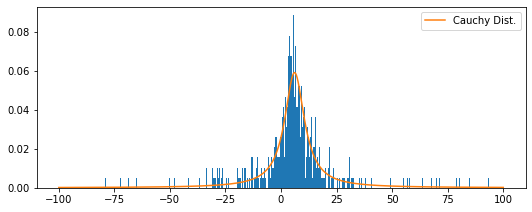

In [62]:
size=1000;

x_ray = np.linspace(-100, 100, 10000);
likelihood = cauchy(xL, yL)
xd = likelihood.rvs(size);

fig,ax = plt.subplots(1,1,figsize=get_figsize(columnwidth,wf=1.85,hf=0.38));
ax.hist(xd, bins=np.arange(-100., 100., 0.2), density=True);
ax.plot(x_ray, likelihood.pdf(x_ray), label='Cauchy Dist.');
ax.legend()

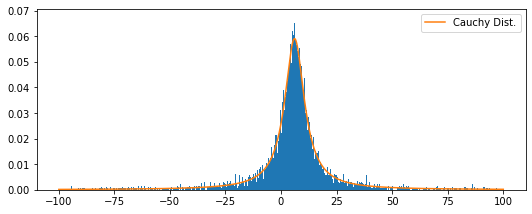

In [61]:
size=10000;

likelihood = cauchy(xL, yL)
xd = likelihood.rvs(size);

fig,ax = plt.subplots(1,1,figsize=get_figsize(columnwidth,wf=1.85,hf=0.38));
ax.hist(xd, bins=np.arange(-100., 100., 0.2), density=True);
ax.plot(x_ray, likelihood.pdf(x_ray), label='Cauchy Dist.');
ax.legend()

**Comment**: Looks like on the order of 10000pts is pretty good for determining the distribution....

## Defining Log(PDFs)

In [66]:
def log_prior(x, y, x_min=-10, x_max=+10, y_max = 10):
    if (x > x_min) and (x < x_max) and (y > 0) and (y < y_max):
        return -1.0 * np.log(x_max - x_min) - np.log(y_max)
    else:
        return -np.inf
    
def log_likelihood(x, y, obs_data): 
    L_set = np.log(y) - np.log(y**2 + (obs_data - x)**2)
    return sum(L_set)

def posterior_calc(x_ray, y_ray, obs_data, x_min=-10., x_max=+10., y_max=10):
    
    log_L_pts = [[log_likelihood(x, y, obs_data) for x in x_ray] for y in y_ray]
    
    log_L_pts -= np.amax(log_L_pts)  # subtract maximum of log likelihood

    log_prior_pts = [[log_prior(x, y, x_min, x_max, y_max) for x in x_ray] for y in y_ray]

    posterior_pts = np.exp(log_prior_pts + log_L_pts)
    return posterior_pts

In [70]:
x_ray = np.arange(-12.0, 12.0, 0.01);
y_ray = np.arange(0.0, 12.0, 0.01);

size = 1000;

likelihood = cauchy(xL, yL)
xd = likelihood.rvs(size);

num = size;
obs_data = xd[:num];
xlim = 10;

posterior_pts = posterior_calc(x_ray, y_ray, obs_data, x_min=-xlim, x_max=xlim, y_max=xlim);

/var/folders/k7/9jypb0dx433fx7bbdx3xmwqm8x67ts/T/ipykernel_30038/3716643686.py:8: RuntimeWarning: divide by zero encountered in log
  L_set = np.log(y) -np.log(y**2 + (obs_data - x)**2)


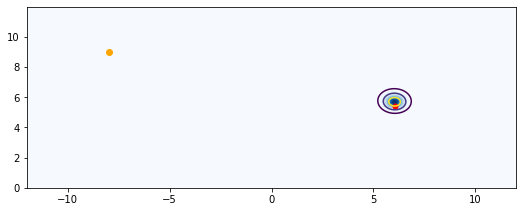

In [153]:
fig,ax = plt.subplots(1,1,figsize=get_figsize(columnwidth,wf=1.85,hf=0.38));

ax.contourf(x_ray, y_ray, posterior_pts, 100, cmap='Blues')
ax.contour(x_ray, y_ray, posterior_pts, contour_levels(posterior_pts))
ax.scatter(xL, yL, color='r', s=25)
ax.scatter(np.mean(xd), FWHM(hist[1][:-1], hist[0]), color='orange')

(3.0, 8.0)

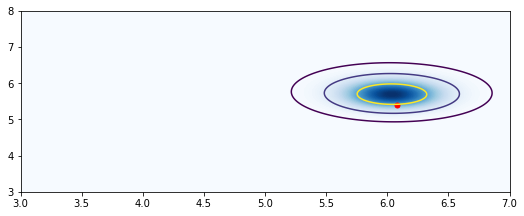

In [154]:
fig,ax = plt.subplots(1,1,figsize=get_figsize(columnwidth,wf=1.85,hf=0.38));

ax.contourf(x_ray, y_ray, posterior_pts, 100, cmap='Blues')
ax.contour(x_ray, y_ray, posterior_pts, contour_levels(posterior_pts))
ax.scatter(xL, yL, color='r', s=25)
ax.set_xlim(3.0, 7.0)
ax.set_ylim(3.0, 8.0)

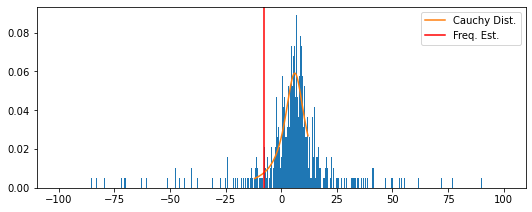

In [110]:
fig,ax = plt.subplots(1,1,figsize=get_figsize(columnwidth,wf=1.85,hf=0.38));
ax.hist(xd, bins=np.arange(-100., 100., 0.2), density=True);
ax.plot(x_ray, likelihood.pdf(x_ray), label='Cauchy Dist.');
plt.axvline(np.mean(xd), color='r', label='Freq. Est.')
ax.legend()

/var/folders/k7/9jypb0dx433fx7bbdx3xmwqm8x67ts/T/ipykernel_30038/3716643686.py:8: RuntimeWarning: divide by zero encountered in log
  L_set = np.log(y) -np.log(y**2 + (obs_data - x)**2)


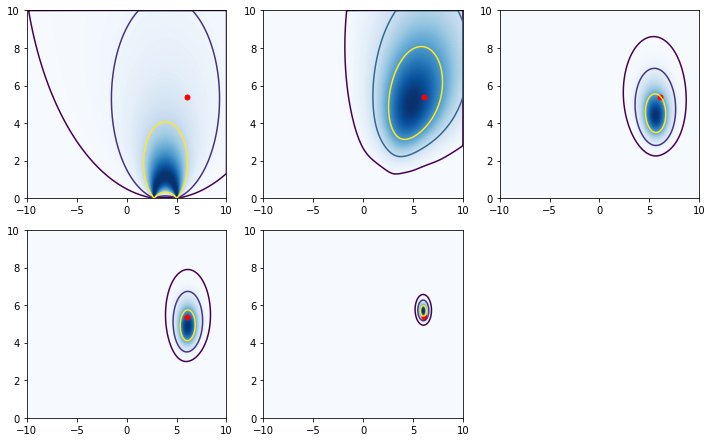

In [157]:
size_ray = [2, 10, 50, 100, 1000];

fig = plt.figure(figsize=(10, 1.25*len(size_ray)))

for k, size in enumerate(size_ray):
    
    obs_data = xd[:size];
    posterior_pts = posterior_calc(x_ray, y_ray, obs_data, x_min=-xlim, x_max=xlim, y_max=xlim);
    
    ax = fig.add_subplot(int(len(size_ray)/2), 3, k+1);
    ax.contourf(x_ray, y_ray, posterior_pts, 100, cmap='Blues')
    ax.contour(x_ray, y_ray, posterior_pts, contour_levels(posterior_pts))
    ax.scatter(xL, yL, color='r', s=25)
    ax.set_xlim(-xlim, xlim)
    ax.set_ylim(0.0, xlim)
    

fig.tight_layout()

# PyMC3 Monte Carlo Sampling

As we have seen above (and if you run the code) calculating the full PDF by sampling over a fine grid of points takes awhile. If we had bumped up the dimensionality to a a lighthouse in 3-space or a noisy detector with Gaussian error in the outputs $x_{D,real} = x_{D,true} + N(\mu, \sigma)$. The more variables, the higher dimensionality, and sampling from a fine mesh grid is not an efficient or scalable approach.

When such is the problem, sampling the distribution to statistically approximate various quantities of interest (Monte Carlo) is the way to go. PyMC3 provides a great deal of abstraction to writing our own MC code, so as we have seen in the previous notebook, as long as we can define the model and the posterior distribution, we are good to go. We can then use built in NUTS or Metropolic MC to sample the distribution and best estimate the PDF.



In [176]:
with pm.Model() as my_NUTS_model:
    
    def log_xL(value=0, x_min=-10, x_max=10):
        box_vals = np.heaviside(value + x_min, 1.0) * (1 - np.heaviside(value - x_max, 1.0))
        return -1.0 * np.log(x_max - x_min) + np.log(box_vals + 1e-15);
    
    def log_yL(value=0, y_min=0.0, y_max=10):
        box_vals = np.heaviside(value + y_min, 1.0) * (1 - np.heaviside(value - y_max, 1.0))
        return -1.0 * np.log(y_max - y_min) + np.log(box_vals + 1e-15);
    
    def log_likelihood(obs_data): 
        L_set = np.log(YL) - np.log(YL**2 + (obs_data - XL)**2)
        return L_set.sum()
    
    #xL = pm.DensityDist("xL", logp = log_xL);
    #yL = pm.DensityDist("yL", logp = log_yL);
    
    #XL = pm.Normal('xL', mu=0, sigma=20)
    #YL = pm.HalfNormal('yL', sigma=20)
    
    XL = pm.Flat('xL')
    YL = pm.HalfFlat('yL')
    
    obs = pm.DensityDist('obs', logp=log_likelihood, observed=obs_data);
    
    trace_NUTS = pm.sample(1000, tune=1000, return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [yL, xL]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 31 seconds.


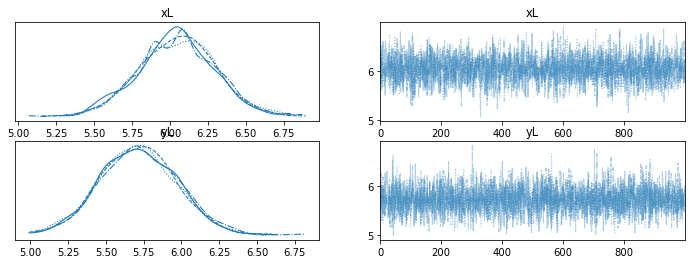

In [177]:
with my_NUTS_model:    
    az.plot_trace(trace_NUTS);

In [179]:
print('True values: xL = 6.08, yL = 5.39')

True values: xL = 6.08, yL = 5.39


In [180]:
with pm.Model() as model:
    display(az.summary(trace_NUTS))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
xL,6.046,0.253,5.588,6.543,0.004,0.003,3165.0,2902.0,1.0
yL,5.717,0.254,5.218,6.174,0.004,0.003,3602.0,2991.0,1.0


## Summary

So above we have taken 